# 미션 11 정리: 한국어–영어 기계 번역 (Seq2Seq & Attention)

## 1. 미션 소개

이번 미션은 **한국어 문장을 영어로 번역하는 기계 번역 모델**을 직접 구현하고 비교하는 프로젝트입니다.  
기본적인 **Seq2Seq(Encoder–Decoder)** 구조와, 여기에 **Attention 메커니즘을 적용한 모델**을 구현하여  
두 모델의 번역 성능을 **정성·정량적으로 비교·분석**하는 것이 핵심입니다.

---

## 2. 미션 목표

- 한국어–영어 병렬 코퍼스를 활용해 **기계 번역 파이프라인 전체를 직접 구현**한다.
- **Seq2Seq (GRU 기반 Encoder–Decoder)** 기본 구조를 이해하고 구현한다.
- **Bahdanau / Luong Attention** 개념을 이해하고, 디코더에 적용해 본다.
- **전처리 → 토크나이징 → 단어 사전 구축 → 텐서 변환 → DataLoader → 모델 학습/평가**  
  전체 흐름을 한 번에 연결하는 실습을 수행한다.
- 단순 구현을 넘어서, **모델 구조/전처리/하이퍼파라미터 변경에 따른 성능 차이**를 관찰한다.

---

## 3. 데이터 소개

- 형식: **JSON 파일**
- 각 샘플 구조:
  - `"ko"`: 한국어 원문 문장
  - `"mt"`: 영어 번역 문장 (machine translation / target)

- 데이터 파일 예시:
  - 훈련 데이터:  
    `.../일상생활및구어체_한영_train_set.json`
  - 검증 데이터:  
    `.../일상생활및구어체_한영_valid_set.json`
  - (실제 경로는 본인 환경에 맞게 수정)

- 데이터 특징:
  - 일상 회화/구어체 중심
  - 한–영 병렬 문장 쌍
  - 문장 길이 분포를 파악해 **MAX_LENGTH** 설정 필요

---

## 4. 분석 및 구현 단계

### 4-1. 데이터 전처리

- **토크나이저 선택**
  - 한국어: 띄어쓰기 기반 토큰화 또는 형태소 분석기(선택)
  - 영어: 공백 기반 토큰화 + 간단한 정규화
- 특수 토큰 정의
  - `<sos>`: 시작 토큰 (Start of sentence)
  - `<eos>`: 종료 토큰 (End of sentence)
  - `<pad>`: 패딩 토큰
  - `<unk>`: 미등록 단어 토큰
- 문장 길이 분석
  - 한–영 문장 길이 분포 확인
  - 95% 퍼센타일 등 기준으로 **MAX_LENGTH** 설정  
    (너무 긴 문장은 잘라내거나 제외할 수 있음)

---

### 4-2. 어휘 사전 구축

- 한국어용, 영어용 **별도 vocab** 생성
  - 각 언어별 토큰 빈도 계산
  - 최소 등장 빈도(min_freq) 기준 이하 단어는 `<unk>` 처리
- 단어 → 인덱스 매핑, 인덱스 → 단어 매핑 작성
  - `word2idx_ko`, `idx2word_ko`
  - `word2idx_en`, `idx2word_en`
- 사전 크기 및 OOV 비율 확인

---

### 4-3. 텐서 변환 및 DataLoader 구현

- 각 문장에 대해:
  - 토큰 리스트 → 인덱스 시퀀스 변환
  - `<sos>`, `<eos>` 토큰 추가 (특히 디코더 입력/타깃에 주의)
  - `MAX_LENGTH`에 맞추어 `<pad>`로 패딩
- 텐서 구성:
  - `src_tensor` (한국어 인덱스 시퀀스)
  - `tgt_tensor` (영어 인덱스 시퀀스)
- `TensorDataset`, `DataLoader` 활용:
  - `train_loader`, `valid_loader`
  - `batch_size`, `shuffle` 등 설정

---

### 4-4. 모델 구현 (Seq2Seq 기본 모델)

- **Encoder (GRU 기반)**
  - 입력: 한국어 인덱스 시퀀스
  - Embedding → GRU → 최종 hidden state 반환
- **Decoder (GRU 기반)**
  - 입력: 이전 시점 디코더 출력 단어(or `<sos>`)의 인덱스
  - Embedding → GRU → Linear → 영어 단어 분포 출력
- **Teacher Forcing 적용**
  - 일정 비율로, 디코더 입력에 “모델 예측” 대신 “정답 토큰” 사용
  - 학습 안정화 및 수렴 속도 향상에 도움

---

### 4-5. Attention 적용 모델 구현

- **Bahdanau Attention 또는 Luong Attention** 중 하나 선택/구현
- Attention 구조:
  - Encoder의 모든 hidden state를 활용
  - Decoder의 현재 hidden state와 결합해 attention score 계산
  - 가중합(context vector) + Decoder hidden → 단어 예측
- 기대 효과:
  - 긴 문장에서 **어느 부분을 참고할지 가중치를 학습**함으로써  
    단순 Seq2Seq 대비 번역 품질 향상

---

### 4-6. 모델 학습 및 추론

- 학습 루프 구현:
  - Epoch별 Train Loss/Valid Loss 기록
  - Teacher Forcing 비율 조절(고정 또는 점진 감소)
- 임의 문장 샘플링 후:
  - Encoder → Decoder로 번역 생성
  - `<sos>`, `<eos>`, `<pad>` 제거 후 깔끔한 문장으로 복원
- Attention 모델의 경우:
  - 가능하다면 Attention weight를 시각화(선택)

---

## 5. 모델 성능 평가

### 5-1. 정성적 평가

- 임의의 한–영 문장 쌍에 대해:
  - 원문(ko), 정답 번역문(gt), 모델 번역(pred)을 함께 출력
  - Seq2Seq vs Attention 모델의 번역 결과 비교
  - 어순, 의미 전달, 자연스러운 표현 여부를 사람이 직접 확인

### 5-2. 정량적 평가 (선택)

- **BLEU 점수** 등 기계 번역 전용 지표 도입 가능
  - N-gram 기반 일치율 평가
- Validation / Test 데이터셋에 대해:
  - 모델별 평균 BLEU 점수 비교
  - 단순 Loss/Accuracy보다 번역 품질을 더 잘 반영


# 데이터 준비

## 라이브러리 로드 및 환경설정

In [1]:
import json
import math
import random
import re
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# 시각화 일관성 유지 (seaborn 스타일)
plt.style.use('seaborn-v0_8')

# 시드 고정
SEED = 42

def set_seed(seed=42):
    """
    시드를 고정하는 함수 random, numpy, torch에 대해 시드를 고정
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 사용할 하이퍼파라미터 및 경로 설정 딕셔너리
CONFIG = {
    'data_dir': Path('/mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11'),
    'train_file': '일상생활및구어체_한영_train_set.json',
    'valid_file': '일상생활및구어체_한영_valid_set.json',
    'eda_sample': 10000,                # EDA용 샘플 개수
    'train_limit': 50000,               # 학습에 사용할 최대의 샘플수
    'valid_limit': 1000,                # 검증에 사용할 최대의 샘플수
    'min_freq': 2,                      # 단어장에 포함될 최소 단어 빈도수
    'max_langth': 40,                   # 문장의 최대 길이
    'batch_size': 64,                   # 배치 크기
    'embedding_dim': 128,               # 임베딩 차원
    'hidden_dim': 256,                  # RNN/GRU/LSTM의 은닉 상태 차원
    'teacher_forcing': 0.5,             # Teacher Forcing 비율
    'learning_rate': 1e-3,              # 학습률
    'epochs': 50,           
}
print("\n[CONFIG]")
for k, v in CONFIG.items():
    print(f'- {k}: {v}')

Using device: cuda

[CONFIG]
- data_dir: /mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11
- train_file: 일상생활및구어체_한영_train_set.json
- valid_file: 일상생활및구어체_한영_valid_set.json
- eda_sample: 10000
- train_limit: 50000
- valid_limit: 1000
- min_freq: 2
- max_langth: 40
- batch_size: 64
- embedding_dim: 128
- hidden_dim: 256
- teacher_forcing: 0.5
- learning_rate: 0.001
- epochs: 50


## 데이터 파일 확인하기

원본 JSON파일을 무작위 추출

In [2]:
def load_json_pairs(path, limit=None, seed=SEED):
    """
    JSON 파일에서 문장 쌍을 로드하는 함수
    """
    with open(path, encoding='utf-8') as f:
        data = json.load(f)['data']         # 전체 데이터 리스트 추출
    # limit가 지정되어 있고, 실제 데이터 길이보다 작으면 부분 샘플링 수행
    if limit is not None and limit < len(data):
        rng = random.Random(seed)                       # 전역 random 시퀀스에 영향을 주지않고, 함수 내부 샘플린만 고정
        idx = rng.sample(range(len(data)), limit)       # 전체 인덱스 범위에서 limit 개수만큼 중복없이 랜덤 샘플링      
        data = [data[i] for i in idx]
    return data

# CONFIG에서 데이터 디렉터리 가져오기
data_dir = CONFIG['data_dir']
# EDA에 사용할 학습 데이터 일부 로드
raw_train = load_json_pairs(data_dir / CONFIG['train_file'], limit=CONFIG['eda_sample'])

print(f'EDA용 학습 데이터 샘플 수: {len(raw_train)}')
print(f'예시 3건:')
for sample in raw_train[:3]:
    print('KO:', sample['ko'])
    print('EN:', sample['en'])
    print('-' * 40)

EDA용 학습 데이터 샘플 수: 10000
예시 3건:
KO: 그리고 더블 크립 제품이 하자 없는 배송 부탁드립니다.
EN: And please deliver the double creep product without defects.
----------------------------------------
KO: 날씨 보호 테크 시스템, 특허받은 용접 모서리 및 반전된 솔기가 물을 막아줍니다.
EN: Weather protection tech system, patented welded edges and inverted seams keep water out.
----------------------------------------
KO: 무엇을 도와드릴까요?
EN: How may I help you?
----------------------------------------


## EDA

In [3]:
def simple_tokenize(text, lang='ko'):
    """
    단순한 롤 기반 토크나이저
    """
    # 양끝 공백 제거 및 소문자 변환
    text = text.strip().lower()
    # 언어별 토큰화
    if lang == 'ko':
        # 'ko'에서 0-9//A-Z//a-z//가-힣//ㄱ-ㅎ//ㅏ-ㅣ//!?.,'"<<해당되지 않으면 공백으로 치환
        text = re.sub(r"[^0-9A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ!?.,'\" ]+", " ", text)
    else:
        # 'en'에서 a-z//0-9//!?.,'"//해당되지 않으면 공백으로 치환
        text = re.sub(r"[^a-z0-91?,.'\"]+", " ", text)
    text = re.sub(r'\s+', ' ', text)  # 여러 공백을 하나로 치환
    return [tok for tok in text.split(' ') if tok]  # 공백 기준 토큰 분리 및 빈 토큰 제거

# raw_train 리스트를 DataFrame으로 변환
eda_df = pd.DataFrame(raw_train)
eda_df['ko_len'] = eda_df['ko'].apply(lambda x: len(simple_tokenize(x, 'ko')))
eda_df['en_len'] = eda_df['mt'].apply(lambda x: len(simple_tokenize(x, 'en')))

print(eda_df[['ko_len', 'en_len']].describe())

             ko_len        en_len
count  10000.000000  10000.000000
mean       6.575200      9.870300
std        3.944782      5.910175
min        1.000000      1.000000
25%        4.000000      5.000000
50%        6.000000      9.000000
75%        9.000000     13.000000
max       37.000000     48.000000


맥스 값 확인 후 max_length 40으로 조정

## 시각화

In [4]:
# 한글 폰트 설정
import matplotlib.font_manager as fm, matplotlib as mpl
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["axes.unicode_minus"] = False
print("Matplotlib 한글 폰트 설정 완료")

Matplotlib 한글 폰트 설정 완료


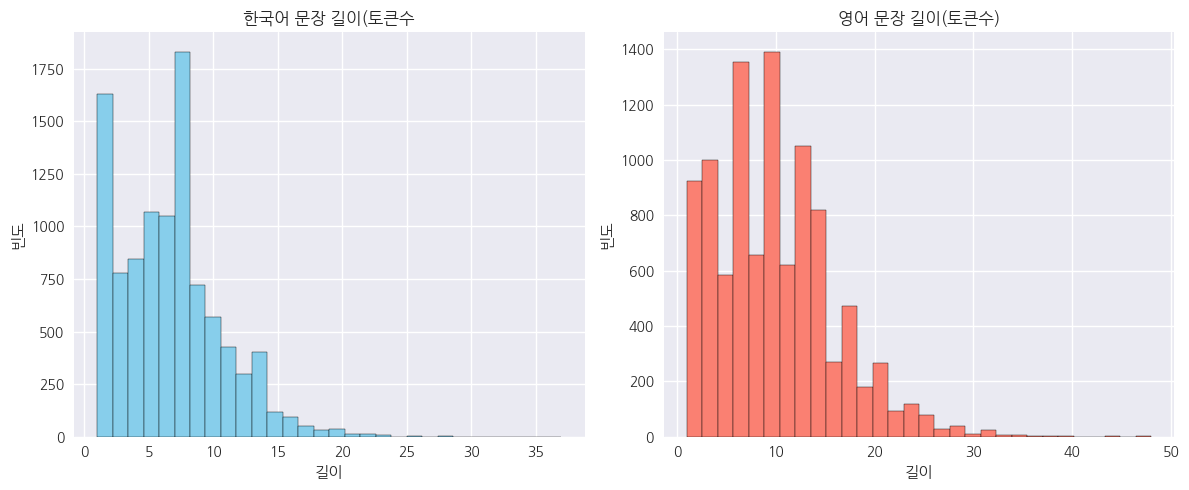

In [5]:
# 데이터 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(eda_df['ko_len'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('한국어 문장 길이(토큰수')
axes[0].set_xlabel('길이')
axes[0].set_ylabel('빈도')

axes[1].hist(eda_df['en_len'], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('영어 문장 길이(토큰수)')
axes[1].set_xlabel('길이')
axes[1].set_ylabel('빈도')

plt.tight_layout()
plt.show()

한국어 문장 길이는 대부분인 3~10토큰 구간에 몰려 있는 반면에 영어는 좀더 전체적으로 분포되어 있음을 알수 있다. 더불어 영어는 40~50토큰에도 드물게 분포되어 있음을 알수 있다. 여기서 max_length를 40으로 두었는데 대부분 문장이 10~15사이인것을 보면 실제 유효 토큰 보다 pad토큰이 더많을 확율이 높아 보인다. 조절할지 판단해볼 것!

In [6]:
ko_p95 = eda_df['ko_len'].quantile(0.95)
en_p95 = eda_df['en_len'].quantile(0.95)

print('한국어 95퍼센타일 길이:', ko_p95)
print('영어  95퍼센타일 길이:', en_p95)

한국어 95퍼센타일 길이: 14.0
영어  95퍼센타일 길이: 21.0


In [7]:
all_quantile = eda_df[['ko_len', 'en_len']].quantile([0.5, 0.9, 0.95, 0.99])

print(all_quantile)

      ko_len  en_len
0.50     6.0     9.0
0.90    12.0    18.0
0.95    14.0    21.0
0.99    18.0    27.0


메모리 효율 및 패딩 비율을 위해 max_length 25로 조정

In [8]:
# 최빈값 확인

ko_counter = Counter()
en_counter = Counter()
for row in raw_train:
    # 한국어 토큰화 후 빈도 업데이트
    ko_counter.update(simple_tokenize(row['ko'], 'ko'))
    # 영어 토큰화 후 빈도 업데이트
    en_counter.update(simple_tokenize(row['mt'], 'en'))

print('한국어 최빈 단어 10개:')
for word, freq in ko_counter.most_common(10):
    print(f'{word:>10} : {freq}')

print('\n영어 최빈 단어 10개:')
for word, freq in en_counter.most_common(10):
    print(f'{word:>10} : {freq}')

한국어 최빈 단어 10개:
     있습니다. : 833
         수 : 825
        저희 : 387
         이 : 319
        있는 : 270
      합니다. : 236
         더 : 231
         것 : 202
         한 : 187
        대해 : 183

영어 최빈 단어 10개:
       the : 4359
        to : 2869
         a : 2348
       you : 2337
       and : 1997
         i : 1902
        is : 1719
        of : 1654
        it : 1533
        in : 1248


한국어는 존대어가 많음을 알수 있다. 영어에는 전치사가 많음을 알수 있다. 다만 seq2seq를 사용할 예정이기에 불용어를 제거하지 않는 것으로 결정 한다. 여기서 고민은 한국어 "있습니다."에서 "." 마침표인데, 이번에는 제거 없이 진행하는 것으로 해본다.

# 데이터 전처리

## 텍스트 정리 및 토큰화

In [9]:
# 테스트 정리 및 토큰화

def clean_and_tokenize(text, lang):
    text = text.strip().lower()
    if lang == 'ko':
        text = re.sub(r"[^0-9A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ!?.,'\" ]+", " ", text)
    else:
        text = re.sub(r"[^a-z0-91?,.'\"]+", " ", text)
    text = re.sub(r'\s+', ' ', text)
    return [tok for tok in text.split(' ') if tok]

# 원본 JSON 항목리스트를 소스토큰 리스트, 타깃토큰 리스트로 쌍으로 변환
def build_dataset(raw_items, lang_pair):
    src_lang, tgt_lang = lang_pair                              # 언어 쌍 언팩킹
    pairs = []
    for item in raw_items:
        src_tokens = clean_and_tokenize(item[src_lang], 'ko')   # 한국어 문장 토큰화
        tgt_tokens = clean_and_tokenize(item[tgt_lang], 'en')   # 영어 문장 토큰화
        # 둘 중 하나라도 빈 토큰 리스트면 무시
        if src_tokens and tgt_tokens:
            pairs.append((src_tokens, tgt_tokens))
    return pairs

# 학습/검증용 JSON 데이터 로드
train_raw = load_json_pairs(data_dir / CONFIG['train_file'], limit=CONFIG['train_limit'])
valid_raw = load_json_pairs(data_dir / CONFIG['valid_file'], limit=CONFIG['valid_limit'])

# 토큰화된 쌍으로 변환
train_pairs = build_dataset(train_raw, ('ko', 'mt'))
valid_pairs = build_dataset(valid_raw, ('ko', 'mt'))

print(f' 학습 샘플 수: {len(train_pairs)}, 검증 샘플 수: {len(valid_pairs)}')
print('학습 샘플 예시 3건:')
for src, tgt in train_pairs[:3]:
    print('KO:', src)
    print('EN:', tgt)
    print('-' * 40)

 학습 샘플 수: 50000, 검증 샘플 수: 1000
학습 샘플 예시 3건:
KO: ['그리고', '더블', '크립', '제품이', '하자', '없는', '배송', '부탁드립니다.']
EN: ['also,', 'please', 'ensure', 'that', 'the', 'double', 'creep', 'product', 'is', 'delivered', 'without', 'defects.']
----------------------------------------
KO: ['날씨', '보호', '테크', '시스템,', '특허받은', '용접', '모서리', '및', '반전된', '솔기가', '물을', '막아줍니다.']
EN: ['weather', 'protection', 'tech', 'system,', 'patented', 'welded', 'edges', 'and', 'inverted', 'seams', 'keep', 'water', 'out.']
----------------------------------------
KO: ['무엇을', '도와드릴까요?']
EN: ['how', 'may', 'i', 'help', 'you?']
----------------------------------------


## 사전 만들기

가장 많이 쓰이는 단어부터 인덱스를 부여 `<pad>`, `<sos>`, `<eos>`, `<unk>`를 항상 포함

In [30]:
class Vocabulary:
    def __init__(self, min_freq):
        self.min_freq = min_freq        # min_freq 횟수 이상의 단어들만 추가(min_freq=2)
        self.special_tokens = ['<pad>', '<sos)', '<eos>', '<unk>']
        self.token2idx: Dict[str, int] = {}
        self.idx2token: Dict[int, str] = {}
        # 특수 토큰부터 차례대로 추가
        for token in self.special_tokens:
            self.add_token(token)
    
    # 새로운 토큰을 사전에 추가하는 메서드
    def add_token(self, token):
        if token not in self.token2idx:
            # 현재까지 등록된 토큰개수 = 새 토큰의 인덱스
            idx = len(self.token2idx)
            self.token2idx[token] = idx         # eksdj->인덱스 매핑 추가
            self.idx2token[idx] = token         # 인덱스->토큰 매핑 추가

    # 여러 문장을 받아서 사전을 구축하는 메서드
    def build(self, sentences):
        counter = Counter()
        for sent in sentences:                  # 각 문장에 등장하는 토큰들을 카운트에 누적
            counter.update(sent)

        for token, freq in counter.items():     # 카운트된 토큰들 중에서
            if freq >= self.min_freq:           # min_freq 이상인 토큰들만 사전에 추가
                self.add_token(token)

    # 토큰을 인덱스로 변환하는 메서드
    def encode(self, tokens, max_len):
        tokens = tokens[: max_len -2]            # 최대 길이-2 만큼 자르기 (<sos>, <eos>를 위한 공간 확보)
        ids = [self.token2idx['<sos>']]          # 시작 토큰 인덱스 추가
        ids += [self.token2idx.get(tok, self.token2idx['<unk>']) for tok in tokens]  # 토큰 인덱스 추가
        ids.append(self.token2idx['<eos>'])          # 종료 토큰 인덱스 추가
        return ids
    
    # 인덱스를 토큰으로 변환하는 메서드
    def decode(self, ids):
        words = []
        for idx in ids:
            token = self.idx2token.get(int(idx), '<unk>')   # 정수 인덱스를 안전하게 int로 변환 후 lookup
            if token == '<eos>':                             # 종료 토큰 나오면 중단
                break
            if token not in {'<sos>', '<pad>'}:             # <pad>, <sos>는 출력 문장에는 포함하지 않음
                words.append(token)
        return words
    
    @property
    def pad_id(self) -> int:
        # 패딩 토큰의 인덱스를 바로 가져올 수 있는 편의 프로퍼티
        return self.token2idx['<pad>']
    
    @property
    def size(self) -> int:
        # 현재 vocab에 등록된 전체 토큰 개수
        return len(self.token2idx)

In [21]:
# 사전 생성

src_vocab = Vocabulary(min_freq=1)         # 소스(한국어) 문장을 위한 vocab 객체 생성
src_vocab.build([src for src, _ in train_pairs])            # build 내부에서 토큰의 빈도를 세고, min_freq 이상인 토큰만 등록

tgt_vocab = Vocabulary(min_freq=CONFIG['min_freq'])         # 타깃(영어) 문장을 위한 vocab 객체 생성
tgt_vocab.build([tgt for _, tgt in train_pairs])            # train_pairs에서 타깃 문장들만 모아서 vocab 구축

# vocab.size 프로퍼티를 통해 전체 단어 개수 출력
print(f'소스(한국어) 단어장 크기: {src_vocab.size}')
print(f'타깃(영어) 단어장 크기: {tgt_vocab.size}')

# 실제 vocab 내용 일부 확인
print('소스(한국어) 단어장 샘플 20개:', list(src_vocab.token2idx.items())[:20])
print('타깃(영어) 단어장 샘플 20개:', list(tgt_vocab.token2idx.items())[:20])

소스(한국어) 단어장 크기: 82264
타깃(영어) 단어장 크기: 15432
소스(한국어) 단어장 샘플 20개: [('<pad>', 0), ('<sos)', 1), ('<eos>', 2), ('<unk>', 3), ('그리고', 4), ('더블', 5), ('크립', 6), ('제품이', 7), ('하자', 8), ('없는', 9), ('배송', 10), ('부탁드립니다.', 11), ('날씨', 12), ('보호', 13), ('테크', 14), ('시스템,', 15), ('특허받은', 16), ('용접', 17), ('모서리', 18), ('및', 19)]
타깃(영어) 단어장 샘플 20개: [('<pad>', 0), ('<sos)', 1), ('<eos>', 2), ('<unk>', 3), ('also,', 4), ('please', 5), ('ensure', 6), ('that', 7), ('the', 8), ('double', 9), ('product', 10), ('is', 11), ('delivered', 12), ('without', 13), ('defects.', 14), ('weather', 15), ('protection', 16), ('tech', 17), ('system,', 18), ('patented', 19)]


In [22]:
# 희귀단어 비율 계산

def oov_ratio(pairs, vocab, lang='src'):
    total_tokens = 0
    oov_tokens = 0
    for src, tgt in pairs:
        tokens = src if lang == 'src' else tgt
        total_tokens += len(tokens)
        for tok in tokens:
            if tok not in vocab.token2idx:
                oov_tokens += 1
    return oov_tokens / total_tokens

print('소스 OOV 비율(대략):', oov_ratio(train_pairs, src_vocab, 'src'))
print('타깃 OOV 비율(대략):', oov_ratio(train_pairs, tgt_vocab, 'tgt'))

소스 OOV 비율(대략): 0.0
타깃 OOV 비율(대략): 0.02803422196476531


|소스(한국어) 단어장|크기 : 26800|OOV비율: 약17%|
|-|-|-|
|소스(영어) 단어장|크기 : 15432|OOV비율: 약3%|

한국어 정보 손실에 대한 우려가 있다. min_freq = 2 설정이 한번만나온 단어는 무조건 <unk>처리 되는데, 한국어 형태소/서브워크 처리를 안해서 발생한 상태라 볼수 있다. 반면 타깃인 영어의 희귀 비율은 꽤나 양호 한편이여서 한국어의 min_freq의 값을 1로 조정을 고려한다.

<반영 후>
|소스(한국어) 단어장|크기 : 82264|OOV비율: 0%(모든단어)|
|-|-|-|
|소스(영어) 단어장|크기 : 15432|OOV비율: 약3%|

## Dataset / DataLoader

Torch에서 바로 읽을 수 있도록 Dataset 클래스를 만들어 정수 시퀀스를 반환한다. 패딩은 collate_fn에서 수행

In [27]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab, max_length):
        # 모든 토큰리스트  쌍들을 받아 모델이 사용할수 있는 인덱스 시퀀스로 바꿔주는 dataset 래퍼
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_length = max_length

    def __len__(self):
        #전체 샘플 개수 반환 >> len(dataset)사용시 반환
        return len(self.pairs)
    
    def __getitem__(self, idx):
        # 인덱스로 샘플 하나를 꺼낼때 호출되는 메서드
        src_tokens, tgt_tokens = self.pairs[idx]
        # 토큰 리스스 >> 인덱스 리스트 >> torch.Tensor 변환
        src_ids = torch.tensor(self.src_vocab.encode(src_tokens, self.max_length), dtype=torch.long)
        tgt_ids = torch.tensor(self.tgt_vocab.encode(tgt_tokens, self.max_length), dtype=torch.long)
        return src_ids, tgt_ids
    
def collate_fn(batch):
    # DataLoader가 배치를 만들때 사용하는 collate 함수
    src_batch, tgt_batch = zip(*batch)   # 배치의 각 요소를 언패킹

    # 각 시퀀스의 실제 길이를 미리계산
    src_lengths = torch.tensor([len(seq) for seq in src_batch])
    tgt_lengths = torch.tensor([len(seq) for seq in tgt_batch])
    
    # pad_sequence로 같은 길이로 패딩
    src_padded = nn.utils.rnn.pad_sequence(
        src_batch, batch_first=True, padding_value=src_vocab.pad_id
    )
    tgt_padded = nn.utils.rnn.pad_sequence(
        tgt_batch, batch_first=True, padding_value=tgt_vocab.pad_id
    )

    # decoder 입력과 타깃 분리
    decoder_inputs = tgt_padded[:, :-1]        # 디코더 RNN에 넣을 입력 시퀀스
    decoder_targets = tgt_padded[:, 1:]        # 각 타임스탭에서 맞춰야 하는 정답 토큰
    # 학습에 필요한 모든 정보 반환
    return src_padded, src_lengths, decoder_inputs, decoder_targets, tgt_lengths

In [28]:
# 학습용 검증용 데이터셋 인스턴스 생성
train_dataset = TranslationDataset(
    train_pairs,
    src_vocab,
    tgt_vocab,
    CONFIG['max_langth']
)
valid_dataset = TranslationDataset(
    valid_pairs,
    src_vocab,
    tgt_vocab,
    CONFIG['max_langth']
)

# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn       # dataset에서 정희한 padding/분리 로직 사용
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,              # 검증은 셔플 불필요
    collate_fn=collate_fn
)

print('dataLoader 준비 완료!')

dataLoader 준비 완료!


# 모델 정의

## Seq2Seq

Encoder와 Decoder 모두 GRU 한 층으로 구성, `pack_padded_sequence` 없이 단순히 패딩된 시퀀스를 넣고, 손실계산시 패팅 토큰을 무시하도록

In [ ]:
class Encoder(nn.Module):
    def __init__(self, voacab_size, embedding_dim, hidden_dim, pad_idx):
        super().__init__()
        # 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # GRU 레이어
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, src, lengths):
        # src: (batch_size, src_len) >> 단어 인덱스 시퀀스
        # 단어 인덱스 >> 임베딩 벡터
        embedded = self.embedding(src)
        # GRU인코더 통과
        outputs, hidden = self.gru(embedded)
        # 아직 lengths를 사용하지 않음(pack_padded_sequence 사용시 필요)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx):
        super().__init__()
        # 디코더 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # GRU 레이어
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # 출력층
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_step, hidden):
        # 단어 인덱스를 임베딩으로 변환
        ssㄴㄴㄴㄴㄴ